In [25]:
import os
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import plotly
import plotly.graph_objects as go
import plotly.express as px
import kaleido ##pip install -U kaleido ##to save a plotly fig
import sys 
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.preprocessing import StandardScaler

In [26]:
df1 = pd.read_csv('Stable_Data_CSV.csv')
df2 = pd.read_csv('6wUsingBL.csv')
df_stable = df2[df2.set_index(['participant_id']).index.isin(df1.set_index(['participant_id']).index)]

In [27]:
df_stable_US = df_stable.loc[(df_stable['arm'] == 1)]
df_stable_WN = df_stable.loc[(df_stable['arm'] == 2)]
print(len(df_stable_US))
print(len(df_stable_WN))

31
30


In [42]:
df_stable_US=(df_stable_US[['c_3','sl_1','a_2','q_1','tfi_total.1','tfi_total.2']])
df_stable_WN=(df_stable_WN[['sl_2','r_1','e_1','tfi_total.1','tfi_total.2']])
#x_test_new_df= pd.DataFrame(columns=['c_3','sl_1','sl_2','a_2','r_1','q_1','e_1','tfi'])
x_test_new_df=pd.read_csv('new_test_data_6w_1ts.csv')
x_test_new_df

,c_3,sl_1,sl_2,a_2,r_1,q_1,e_1,tfi
0,2.0,7.0,6.5,6.5,6.0,6.5,7.0,65.5
1,5.0,6.5,6.0,6.0,2.0,4.5,6.0,56.7
2,2.0,8.5,5.5,7.0,4.5,7.5,4.5,78.9


In [29]:
US_checkpoint_path = "model_checkpoints/6w_1ts/US/cp.ckpt"
WN_checkpoint_path = "model_checkpoints/6w_1ts/WN/cp.ckpt"
lr=0.001
n_epochs=200
n_batch_size=10
n_timesteps=1

def data_prep(df):
    sc_x=StandardScaler()
    sc_y=StandardScaler()
    ## Separate dependent and independent features 
    X=df.drop(['tfi_total.2'],axis=1)
    y = df[['tfi_total.2']]
    #Train Test Split
    x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)
    #scale x
    x_scaler=sc_x.fit(x_train)
    x_train=x_scaler.transform(x_train)
    x_test=x_scaler.transform(x_test)
    #scale y
    y_scaler=sc_y.fit(y_train)
    y_train=y_scaler.transform(y_train)
    y_test=y_scaler.transform(y_test)
    # Reshape input to be 3D for LSTM[samples, timesteps, features]
    x_train = x_train.reshape((x_train.shape[0],n_timesteps,x_train.shape[1]))
    x_test = x_test.reshape((x_test.shape[0],n_timesteps,x_test.shape[1]))
    print(x_train.shape,y_train.shape, x_test.shape, y_test.shape)
    return x_train, x_test, y_train, y_test,x_scaler,y_scaler

def create_lstm_model(input_shape):
    tf.keras.backend.clear_session
    input_shape=input_shape
    model = tf.keras.Sequential([
      tf.keras.layers.LSTM(50, activation='relu',input_shape=input_shape),
      tf.keras.layers.Dropout(0.2), # 20% of Neuron will get deactivated during training
      tf.keras.layers.Dense(1,activation = 'linear')                      
    ])             

    model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=lr))
    return model

def train_model(df,ck_path):
    x_train, x_test, y_train, y_test,x_scaler,y_scaler= data_prep(df)
    input_shape=(n_timesteps,x_train.shape[2])
    print(input_shape)
    model = create_lstm_model(input_shape)  # Create a basic model instance
    model.summary() # Display the model's architecture
    # Create a callback that saves the model's weights #save_best_only=True  (to save model)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ck_path, save_weights_only=True,verbose=1)
    # Train the model
    history = model.fit(x_train, y_train, epochs=n_epochs, batch_size=n_batch_size, validation_data=(x_test, y_test),callbacks=[cp_callback], verbose=1, shuffle=False)
    return history,x_scaler,y_scaler

#train lstm_model for US data and WN data seperately
US_history,US_x_scaler,US_y_scaler=train_model(df_stable_US,US_checkpoint_path)
WN_history,WN_x_scaler,WN_y_scaler=train_model(df_stable_WN,WN_checkpoint_path)

(24, 1, 5) (24, 1) (7, 1, 5) (7, 1)
(1, 5)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 50)                11200     
                                                                 
 dropout_16 (Dropout)        (None, 50)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 51        
                                                                 
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


1/3 [=========>....................] - ETA: 1s - loss: 0.8864

2022-05-14 15:38:34.952489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to model_checkpoints/6w_1ts/US/cp.ckpt
3/3 [==============================] - 1s 85ms/step - loss: 0.8405 - val_loss: 1.0750
Epoch 2/200
1/3 [=========>....................] - ETA: 0s - loss: 0.8808
Epoch 2: saving model to model_checkpoints/6w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 28ms/step - loss: 0.8359 - val_loss: 1.0748
Epoch 3/200
1/3 [=========>....................] - ETA: 0s - loss: 0.8790
Epoch 3: saving model to model_checkpoints/6w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 26ms/step - loss: 0.8328 - val_loss: 1.0751
Epoch 4/200


2022-05-14 15:38:35.245854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/3 [=========>....................] - ETA: 0s - loss: 0.8778
Epoch 4: saving model to model_checkpoints/6w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 23ms/step - loss: 0.8298 - val_loss: 1.0755
Epoch 5/200
1/3 [=========>....................] - ETA: 0s - loss: 0.8768
Epoch 5: saving model to model_checkpoints/6w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.8268 - val_loss: 1.0758
Epoch 6/200
1/3 [=========>....................] - ETA: 0s - loss: 0.8759
Epoch 6: saving model to model_checkpoints/6w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.8238 - val_loss: 1.0763
Epoch 7/200
1/3 [=========>....................] - ETA: 0s - loss: 0.8750
Epoch 7: saving model to model_checkpoints/6w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.8209 - val_loss: 1.0765
Epoch 8/200
1/3 [=========>....................] - ETA: 0s - loss: 0.8743
Epoch 8: saving model to model_checkpoints/6w_1ts/US/c

Epoch 41/200
1/3 [=========>....................] - ETA: 0s - loss: 0.7972
Epoch 41: saving model to model_checkpoints/6w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.6595 - val_loss: 1.0007
Epoch 42/200
1/3 [=========>....................] - ETA: 0s - loss: 0.7940
Epoch 42: saving model to model_checkpoints/6w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.6514 - val_loss: 0.9962
Epoch 43/200
1/3 [=========>....................] - ETA: 0s - loss: 0.7908
Epoch 43: saving model to model_checkpoints/6w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.6429 - val_loss: 0.9920
Epoch 44/200
1/3 [=========>....................] - ETA: 0s - loss: 0.7875
Epoch 44: saving model to model_checkpoints/6w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 24ms/step - loss: 0.6342 - val_loss: 0.9878
Epoch 45/200
1/3 [=========>....................] - ETA: 0s - loss: 0.7853
Epoch 45: saving model to model_c

Epoch 78/200
1/3 [=========>....................] - ETA: 0s - loss: 0.6293
Epoch 78: saving model to model_checkpoints/6w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.4775 - val_loss: 0.8779
Epoch 79/200
1/3 [=========>....................] - ETA: 0s - loss: 0.6270
Epoch 79: saving model to model_checkpoints/6w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.4743 - val_loss: 0.8783
Epoch 80/200
1/3 [=========>....................] - ETA: 0s - loss: 0.6238
Epoch 80: saving model to model_checkpoints/6w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.4711 - val_loss: 0.8807
Epoch 81/200
1/3 [=========>....................] - ETA: 0s - loss: 0.6222
Epoch 81: saving model to model_checkpoints/6w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.4679 - val_loss: 0.8803
Epoch 82/200
1/3 [=========>....................] - ETA: 0s - loss: 0.6186
Epoch 82: saving model to model_c

3/3 [==============================] - 0s 22ms/step - loss: 0.3938 - val_loss: 0.7986
Epoch 115/200
1/3 [=========>....................] - ETA: 0s - loss: 0.5035
Epoch 115: saving model to model_checkpoints/6w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.3912 - val_loss: 0.8020
Epoch 116/200
1/3 [=========>....................] - ETA: 0s - loss: 0.4984
Epoch 116: saving model to model_checkpoints/6w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 21ms/step - loss: 0.3904 - val_loss: 0.8037
Epoch 117/200
1/3 [=========>....................] - ETA: 0s - loss: 0.4978
Epoch 117: saving model to model_checkpoints/6w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.3882 - val_loss: 0.7960
Epoch 118/200
1/3 [=========>....................] - ETA: 0s - loss: 0.4944
Epoch 118: saving model to model_checkpoints/6w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.3860 - val_loss: 0.7918
Epoch 119/200


1/3 [=========>....................] - ETA: 0s - loss: 0.3799
Epoch 151: saving model to model_checkpoints/6w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.3096 - val_loss: 0.7280
Epoch 152/200
1/3 [=========>....................] - ETA: 0s - loss: 0.3724
Epoch 152: saving model to model_checkpoints/6w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.3040 - val_loss: 0.7230
Epoch 153/200
1/3 [=========>....................] - ETA: 0s - loss: 0.3704
Epoch 153: saving model to model_checkpoints/6w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.3024 - val_loss: 0.7215
Epoch 154/200
1/3 [=========>....................] - ETA: 0s - loss: 0.3668
Epoch 154: saving model to model_checkpoints/6w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.2995 - val_loss: 0.7221
Epoch 155/200
1/3 [=========>....................] - ETA: 0s - loss: 0.3594
Epoch 155: saving model to model_check

3/3 [==============================] - 0s 22ms/step - loss: 0.2234 - val_loss: 0.7055
Epoch 188/200
1/3 [=========>....................] - ETA: 0s - loss: 0.2702
Epoch 188: saving model to model_checkpoints/6w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.2204 - val_loss: 0.7060
Epoch 189/200
1/3 [=========>....................] - ETA: 0s - loss: 0.2660
Epoch 189: saving model to model_checkpoints/6w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.2191 - val_loss: 0.7075
Epoch 190/200
1/3 [=========>....................] - ETA: 0s - loss: 0.2615
Epoch 190: saving model to model_checkpoints/6w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.2152 - val_loss: 0.7046
Epoch 191/200
1/3 [=========>....................] - ETA: 0s - loss: 0.2625
Epoch 191: saving model to model_checkpoints/6w_1ts/US/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.2151 - val_loss: 0.7051
Epoch 192/200


2022-05-14 15:38:46.829376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to model_checkpoints/6w_1ts/WN/cp.ckpt
3/3 [==============================] - 1s 88ms/step - loss: 0.8926 - val_loss: 0.5270
Epoch 2/200
1/3 [=========>....................] - ETA: 0s - loss: 0.9618
Epoch 2: saving model to model_checkpoints/6w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 24ms/step - loss: 0.8851 - val_loss: 0.5238
Epoch 3/200
1/3 [=========>....................] - ETA: 0s - loss: 0.9547
Epoch 3: saving model to model_checkpoints/6w_1ts/WN/cp.ckpt


2022-05-14 15:38:47.111970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 101ms/step - loss: 0.8782 - val_loss: 0.5204
Epoch 4/200
1/3 [=========>....................] - ETA: 0s - loss: 0.9477
Epoch 4: saving model to model_checkpoints/6w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 23ms/step - loss: 0.8715 - val_loss: 0.5167
Epoch 5/200
1/3 [=========>....................] - ETA: 0s - loss: 0.9407
Epoch 5: saving model to model_checkpoints/6w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 23ms/step - loss: 0.8653 - val_loss: 0.5126
Epoch 6/200
1/3 [=========>....................] - ETA: 0s - loss: 0.9339
Epoch 6: saving model to model_checkpoints/6w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.8590 - val_loss: 0.5084
Epoch 7/200
1/3 [=========>....................] - ETA: 0s - loss: 0.9272
Epoch 7: saving model to model_checkpoints/6w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.8529 - val_loss: 0.5055
Epoch 8/200
1/3 [=========>..

3/3 [==============================] - 0s 28ms/step - loss: 0.6260 - val_loss: 0.4250
Epoch 41/200
1/3 [=========>....................] - ETA: 0s - loss: 0.6820
Epoch 41: saving model to model_checkpoints/6w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 25ms/step - loss: 0.6216 - val_loss: 0.4217
Epoch 42/200
1/3 [=========>....................] - ETA: 0s - loss: 0.6785
Epoch 42: saving model to model_checkpoints/6w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 27ms/step - loss: 0.6171 - val_loss: 0.4189
Epoch 43/200
1/3 [=========>....................] - ETA: 0s - loss: 0.6749
Epoch 43: saving model to model_checkpoints/6w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 25ms/step - loss: 0.6126 - val_loss: 0.4163
Epoch 44/200
1/3 [=========>....................] - ETA: 0s - loss: 0.6707
Epoch 44: saving model to model_checkpoints/6w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 25ms/step - loss: 0.6079 - val_loss: 0.4145
Epoch 45/200
1/3 [====

3/3 [==============================] - 0s 25ms/step - loss: 0.4915 - val_loss: 0.3972
Epoch 78/200
1/3 [=========>....................] - ETA: 0s - loss: 0.5134
Epoch 78: saving model to model_checkpoints/6w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 23ms/step - loss: 0.4891 - val_loss: 0.3974
Epoch 79/200
1/3 [=========>....................] - ETA: 0s - loss: 0.5090
Epoch 79: saving model to model_checkpoints/6w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 24ms/step - loss: 0.4861 - val_loss: 0.3969
Epoch 80/200
1/3 [=========>....................] - ETA: 0s - loss: 0.5065
Epoch 80: saving model to model_checkpoints/6w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 25ms/step - loss: 0.4835 - val_loss: 0.3958
Epoch 81/200
1/3 [=========>....................] - ETA: 0s - loss: 0.5049
Epoch 81: saving model to model_checkpoints/6w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 24ms/step - loss: 0.4814 - val_loss: 0.3948
Epoch 82/200
1/3 [====

3/3 [==============================] - 0s 23ms/step - loss: 0.3620 - val_loss: 0.3344
Epoch 151/200
1/3 [=========>....................] - ETA: 0s - loss: 0.3568
Epoch 151: saving model to model_checkpoints/6w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 23ms/step - loss: 0.3605 - val_loss: 0.3336
Epoch 152/200
1/3 [=========>....................] - ETA: 0s - loss: 0.3567
Epoch 152: saving model to model_checkpoints/6w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 23ms/step - loss: 0.3590 - val_loss: 0.3322
Epoch 153/200
1/3 [=========>....................] - ETA: 0s - loss: 0.3554
Epoch 153: saving model to model_checkpoints/6w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 23ms/step - loss: 0.3574 - val_loss: 0.3320
Epoch 154/200
1/3 [=========>....................] - ETA: 0s - loss: 0.3570
Epoch 154: saving model to model_checkpoints/6w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 24ms/step - loss: 0.3566 - val_loss: 0.3317
Epoch 155/200


1/3 [=========>....................] - ETA: 0s - loss: 0.3268
Epoch 187: saving model to model_checkpoints/6w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 22ms/step - loss: 0.3092 - val_loss: 0.2986
Epoch 188/200
1/3 [=========>....................] - ETA: 0s - loss: 0.3243
Epoch 188: saving model to model_checkpoints/6w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 23ms/step - loss: 0.3061 - val_loss: 0.2978
Epoch 189/200
1/3 [=========>....................] - ETA: 0s - loss: 0.3298
Epoch 189: saving model to model_checkpoints/6w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 23ms/step - loss: 0.3068 - val_loss: 0.2963
Epoch 190/200
1/3 [=========>....................] - ETA: 0s - loss: 0.3312
Epoch 190: saving model to model_checkpoints/6w_1ts/WN/cp.ckpt
3/3 [==============================] - 0s 24ms/step - loss: 0.3054 - val_loss: 0.2956
Epoch 191/200
1/3 [=========>....................] - ETA: 0s - loss: 0.3266
Epoch 191: saving model to model_check

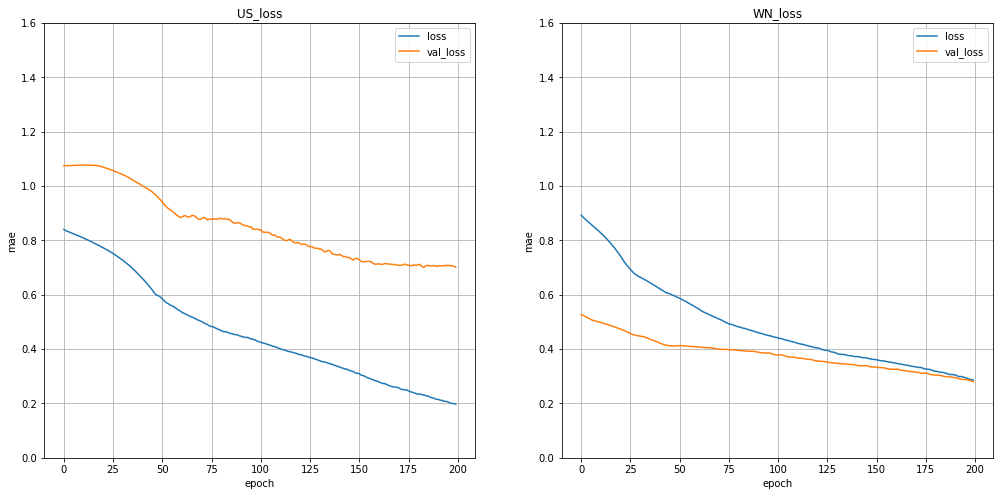

In [30]:
#show learning curves
#mean training loss measured over each epoch
#mean validation loss measured at the end of each epoch
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(17,8))
US_plot = pd.DataFrame(US_history.history) #selecting columns
WN_plot = pd.DataFrame(WN_history.history)
US_plot.plot(ax=axes[0],ylim=(0,1.6),title="US_loss",xlabel='epoch',ylabel='mae').grid(True)
WN_plot.plot(ax=axes[1],ylim=(0,1.6),title="WN_loss",xlabel='epoch',ylabel='mae').grid(True)
plt.savefig("plots/mae_6w_1ts.png")

In [34]:
#create a model with the same architecture as the original model and then set its weights

"""
# To Re-evaluate the model
loss, acc = model_new.evaluate(x_test, y_test, verbose=2)
"""
def lstm_US(test_US):
    test_US=np.reshape(test_US, (1,-1)) #reshape the data for scaling 
    test_US=US_x_scaler.transform(test_US)#scale the data
    test_US = test_US.reshape((test_US.shape[0],n_timesteps,test_US.shape[1])) #reshape the data for prediction
    input_shape=(n_timesteps,test_US.shape[2])
    US_model= create_lstm_model(input_shape)
    US_model.load_weights(US_checkpoint_path) # Loads the weights
    US_yhat=US_model.predict(test_US)
    #reshape the data for scaling
    US_yhat=np.reshape(US_yhat, (1,-1))
    inv_US_yhat=US_y_scaler.inverse_transform(US_yhat)
    inv_US_yhat = inv_US_yhat[0][0]
    return inv_US_yhat

def lstm_WN(test_WN):
    test_WN=np.reshape(test_WN, (1,-1))
    test_WN=WN_x_scaler.transform(test_WN)
    test_WN = test_WN.reshape((test_WN.shape[0],n_timesteps,test_WN.shape[1]))
    input_shape=(n_timesteps,test_WN.shape[2])
    WN_model= create_lstm_model(input_shape)
    WN_model.load_weights(WN_checkpoint_path) # Loads the weights
    WN_yhat=WN_model.predict(test_WN)
    WN_yhat=np.reshape(WN_yhat, (1,-1))
    inv_WN_yhat=WN_y_scaler.inverse_transform(WN_yhat)
    inv_WN_yhat = inv_WN_yhat[0][0]
    return inv_WN_yhat

#test model prediction
US_test=(5.0,8.0,3.0,2.0,100)
WN_test=(5.0,8.0,3.0,60.8)
US_yhat=lstm_US(US_test)
WN_yhat=lstm_WN(WN_test)

print(US_yhat)
print(WN_yhat)

error=mean_absolute_error([[75.08757]],[[US_yhat]])
print(error)

/Users/manjuvallayil/miniforge3/envs/tinnitus/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
2022-05-14 16:09:29.694099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/manjuvallayil/miniforge3/envs/tinnitus/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


79.13925
55.860764
4.0516817089843755


2022-05-14 16:09:29.832498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [41]:
def prediction(c_3,sl_1,sl_2,a_2,r_1,q_1,e_1,tfi):
    #append test inputs to df and save to csv
    x_test_new_df.loc[len(x_test_new_df)] = [c_3,sl_1,sl_2,a_2,r_1,q_1,e_1,tfi]
    x_test_new_df.to_csv('new_test_data_6w_1ts.csv',index=False)
    #separate the features for US and WN
    test_US = (c_3,sl_1,a_2,q_1,tfi)
    test_WN = (sl_2,r_1,e_1,tfi)
    #make predictions
    US_yhat=lstm_US(test_US) # predict using the lstm model 
    US_result="the predicted tfi at 6 weeks is {:.2f}".format(US_yhat)
    WN_yhat=lstm_WN(test_WN) # predict using the lstm model
    WN_result="the predicted tfi at 6 weeks is {:.2f}".format(WN_yhat)
    loss_plot_path='plots/mae_6w_1ts.png'
    return US_result, WN_result,loss_plot_path,pd.read_csv('new_test_data_6w_1ts.csv')
    
import gradio as gr   # pip install gradio
iface = gr.Interface(
    prediction,
    inputs=[gr.inputs.Slider(minimum=1, maximum=10, step=0.5,label="c_3 / Your ability to FOCUS ATTENTION on other things besides your tinnitus?" ),
     gr.inputs.Slider(minimum=1, maximum=10, step=0.5,label="sl_1 / How often did your tinnitus make it difficult to FALL ASLEEP or STAY ASLEEP?" ),
     gr.inputs.Slider(minimum=1, maximum=10, step=0.5,label="sl_2 / How often did your tinnitus cause you difficulty in getting AS MUCH SLEEP as you needed?" ),
     gr.inputs.Slider(minimum=1, maximum=10, step=0.5,label="a_2 / Your ability to UNDERSTAND PEOPLE who are talking?" ),
     gr.inputs.Slider(minimum=1, maximum=10, step=0.5,label="r_1 / Your QUIET RESTING ACTIVITIES?" ),
     gr.inputs.Slider(minimum=1, maximum=10, step=0.5,label="q_1 / Your enjoyment of SOCIAL ACTIVITIES?" ),
     gr.inputs.Slider(minimum=1, maximum=10, step=0.5,label="e_1 / How ANXIOUS or WORRIED has your tinnitus made you feel?" ),
     gr.inputs.Number(label="baseline tfi (tfi_total_4w)", optional=False)],
    outputs=[gr.outputs.Textbox(label="US_therapy",type="auto"),gr.outputs.Textbox(label="WN_therapy",type="auto"),gr.outputs.Image(type="file", label="US and WN Models Training Loss Curves"),gr.outputs.Dataframe(label="Appending New test_data to a file")],
    allow_flagging="never",title="Mid TFI_prediction",description="Please fill in all the fields and click Submit for the tfi_6w prediction"
)

iface.launch(share='TRUE')

Running on local URL:  http://127.0.0.1:7882/
Running on public URL: https://11308.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x165a5bfd0>,
 'http://127.0.0.1:7882/',
 'https://11308.gradio.app')

/Users/manjuvallayil/miniforge3/envs/tinnitus/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
2022-05-14 16:25:08.179840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/manjuvallayil/miniforge3/envs/tinnitus/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
2022-05-14 16:25:08.317238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
